In [47]:
import pandas as pd
from matplotlib import pyplot as plt

# Part 1: Data Preparation and Exploration

In [48]:
dt=pd.read_csv('exchange_rate.csv')
dt

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [49]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [50]:
dt.isnull().sum()

date       0
Ex_rate    0
dtype: int64

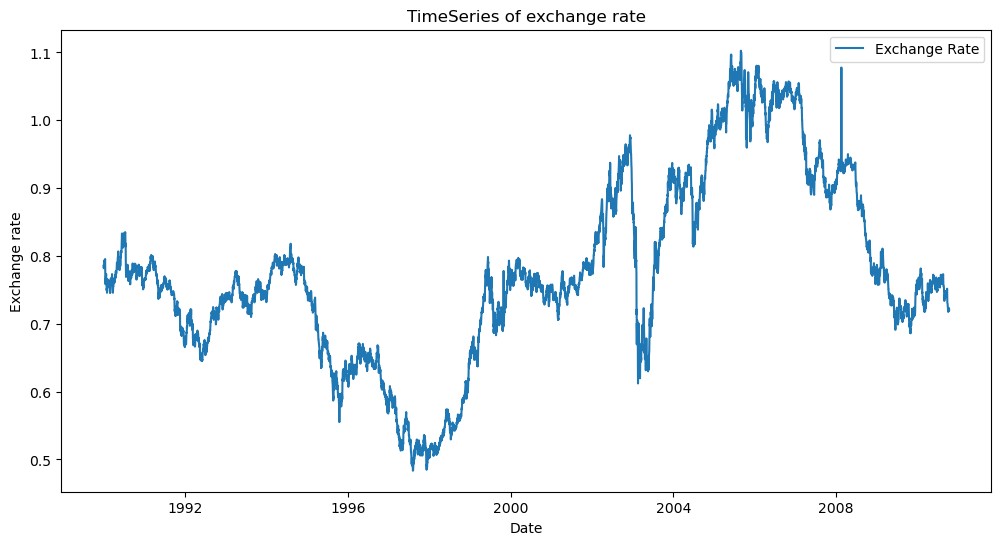

In [51]:
import matplotlib.pyplot as plt
dt['date']=pd.to_datetime(dt['date'],format='%d-%m-%Y %H:%M')
dt.set_index('date',inplace=True)
plt.figure(figsize=(12,6))
plt.plot(dt.index,dt['Ex_rate'],label='Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.title('TimeSeries of exchange rate')
plt.legend()
plt.show()

In [52]:
import numpy as np
z_scores = np.abs((dt['Ex_rate'] - dt['Ex_rate'].mean()) / dt['Ex_rate'].std())
anomalies = dt[z_scores > 3]
print(anomalies)

Empty DataFrame
Columns: [Ex_rate]
Index: []


# Part 2: Model Building - ARIMA

In [53]:
from matplotlib import pyplot
import warnings
import numpy
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [54]:
# Augmented Dickey-Fuller (ADF) test

# import the adfuller function from statsmodel package to perform ADF test
from statsmodels.tsa.stattools import adfuller

# extracting values from data frame
values = dt.values

# passing the extracted values to adfuller function.
res = adfuller(values)
print(res)
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f'  %res[1])

# printing the critical values at different alpha levels and the result of the test.
print('critical values at different levels:')
for k, v in res[4].items():
    print (k, v)
if (res[1] > 0.025):
    print("The time series is non-stationary")

(-1.664994180738073, 0.44923273535983155, 1, 7586, {'1%': -3.4312123140180137, '5%': -2.861921078147796, '10%': -2.5669728434336108}, -55835.06254628545)
Augmneted Dickey_fuller Statistic: -1.664994
p-value: 0.449233
critical values at different levels:
1% -3.4312123140180137
5% -2.861921078147796
10% -2.5669728434336108
The time series is non-stationary


0.0
p value:0.0 , Series is Stationary


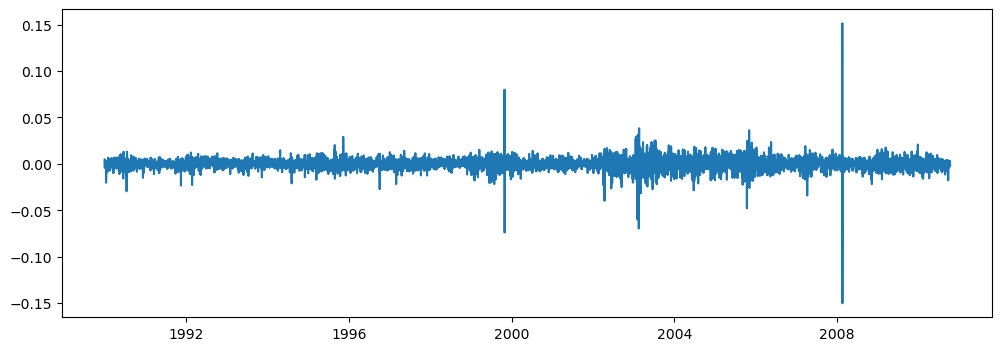

In [55]:
#De-trending with first order differencing
data1 = pd.DataFrame(dt["Ex_rate"].diff())
de_trended = data1.dropna()
adf2 = adfuller(de_trended.values)[1]
print(adf2)

print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
plt.figure(figsize = (12,4))
plt.plot(de_trended);
plt.show()

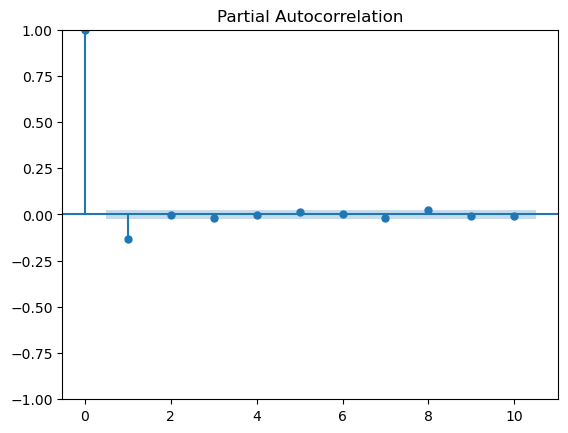

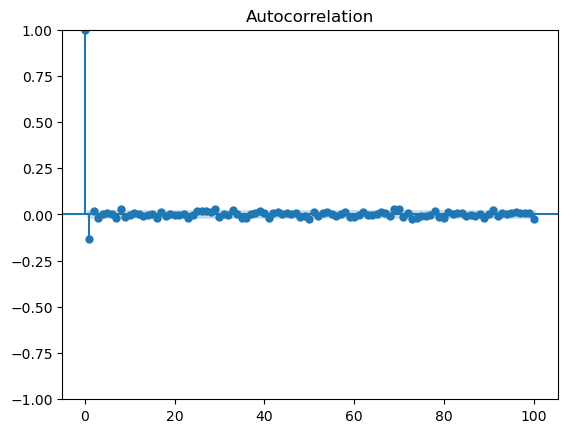

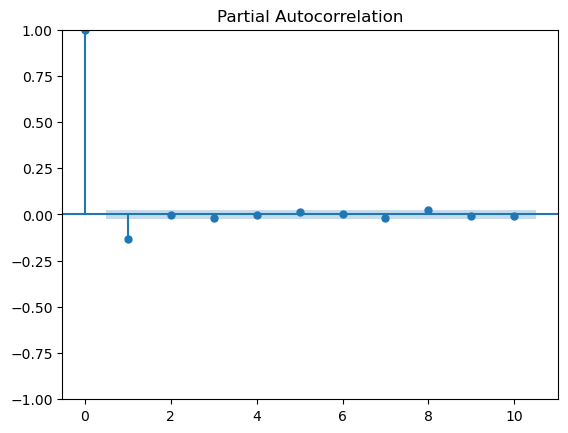

In [10]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(de_trended.values,lags=100)
tsa_plots.plot_pacf(de_trended.values,lags=10)

# Build the model for chosen for p,d,q values of p=2, d=1, q=5


In [56]:
# separate out a validation dataset
split_point = len(dt) - 10
train, validation = dt[0:split_point], dt[split_point:]
#print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
# dataset.to_csv('dataset.csv', header=True)
validation.to_csv('validation.csv', header=True)

In [57]:
# load data
#train = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [58]:
# fit model
model = ARIMA(X, order=(2,1,5))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)
forecast

C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([0.72188458, 0.72191696, 0.721943  , 0.72190267, 0.72191622,
       0.72193084, 0.72190688, 0.7219205 , 0.72192365, 0.72191104])

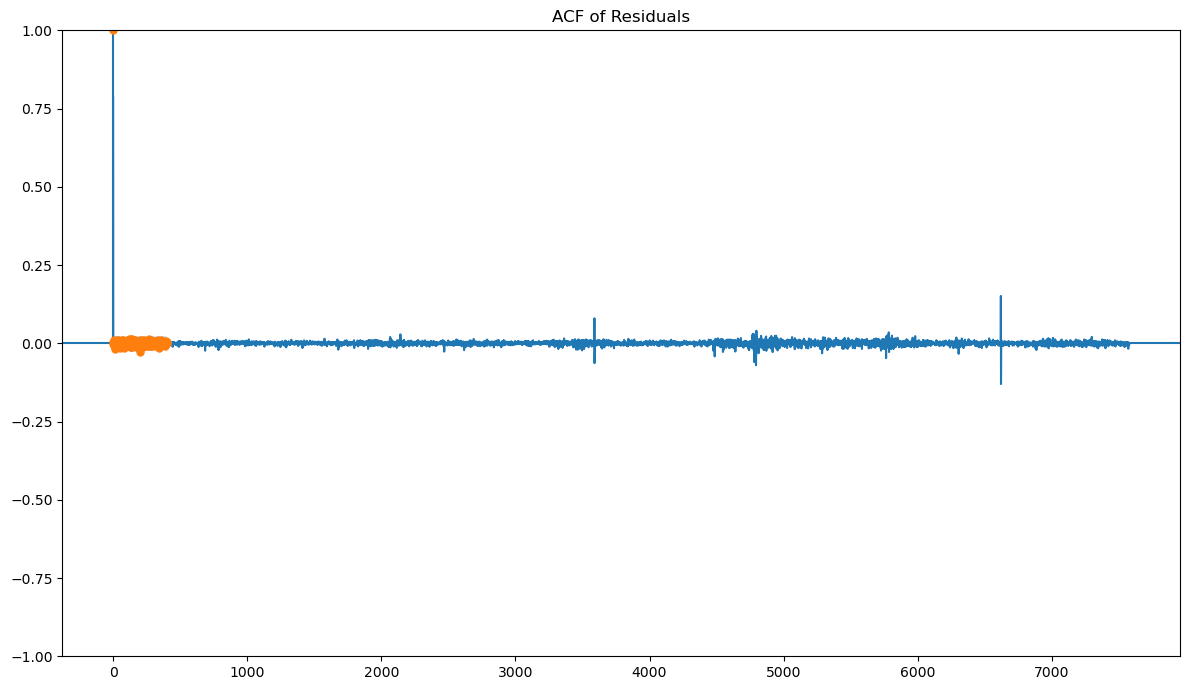

       lb_stat  lb_pvalue
100  23.204543        1.0


In [59]:
from statsmodels.graphics.tsaplots import plot_acf
residuals=model_fit.resid
plt.figure(figsize=(12,7))
plt.plot(residuals)
plt.title('Residuals')

plot_acf(residuals,ax=plt.gca(),lags=400)
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# Perform Ljung-Box test
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[100], return_df=True)
print(ljung_box_results)

In [60]:
test = pd.read_csv("validation.csv")
test

,date,Ex_rate
0,2010-10-01,0.717618
1,2010-10-02,0.719114
2,2010-10-03,0.719114
3,2010-10-04,0.719735
4,2010-10-05,0.718701
5,2010-10-06,0.718494
6,2010-10-07,0.721839
7,2010-10-08,0.723197
8,2010-10-09,0.720825
9,2010-10-10,0.720825


In [61]:
#Error on the test data
val=pd.read_csv('validation.csv')
rmse = np.sqrt(mean_squared_error(val.Ex_rate, forecast))
rmse

0.0025481846449316647

In [62]:
# fit model
data = pd.read_csv('exchange_rate.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = dt.values

In [63]:
X = X.astype('float32')

In [64]:
model = ARIMA(X, order=(2,1,5))
model_fit = model.fit()

In [65]:
forecast=model_fit.forecast(steps=1000)
forecast

array([0.72079799, 0.72088466, 0.72085471, 0.72081887, 0.72087451,
       0.7208442 , 0.72083562, 0.7208652 , 0.7208418 , 0.72084446,
       0.72085808, 0.72084272, 0.7208485 , 0.72085344, 0.72084452,
       0.72084994, 0.72085076, 0.72084618, 0.72085016, 0.72084939,
       0.72084739, 0.72084991, 0.7208488 , 0.72084815, 0.72084956,
       0.72084861, 0.72084857, 0.72084927, 0.7208486 , 0.72084878,
       0.72084907, 0.72084866, 0.72084887, 0.72084895, 0.72084872,
       0.72084889, 0.72084888, 0.72084877, 0.72084889, 0.72084885,
       0.72084881, 0.72084887, 0.72084884, 0.72084883, 0.72084886,
       0.72084883, 0.72084884, 0.72084885, 0.72084884, 0.72084884,
       0.72084885, 0.72084884, 0.72084884, 0.72084885, 0.72084884,
       0.72084884, 0.72084884, 0.72084884, 0.72084884, 0.72084884,
       0.72084884, 0.72084884, 0.72084884, 0.72084884, 0.72084884,
       0.72084884, 0.72084884, 0.72084884, 0.72084884, 0.72084884,
       0.72084884, 0.72084884, 0.72084884, 0.72084884, 0.72084

In [66]:
forecastdata = pd.DataFrame()
forecastdata["forecasted_val"] = forecast

In [67]:
exchange_rate= pd.concat([dt,forecastdata], ignore_index=True)

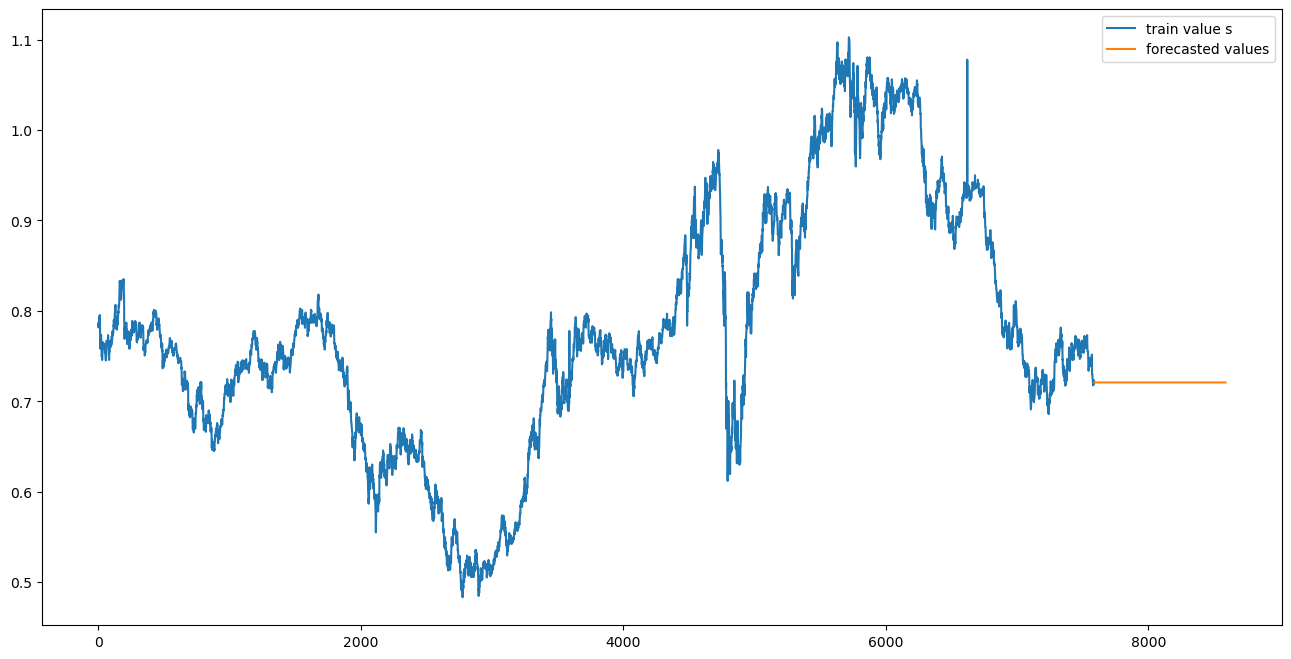

In [23]:
plt.figure(figsize=(16,8))

plt.plot(exchange_rate["Ex_rate"], label='train value s')
plt.plot(exchange_rate["forecasted_val"], label="forecasted values")
plt.legend(loc='best')
plt.show()

# Part 3: Model Building - Exponential Smoothing

In [68]:

from matplotlib import pyplot


In [69]:
train=dt.head(7000)
test=dt.tail(588)

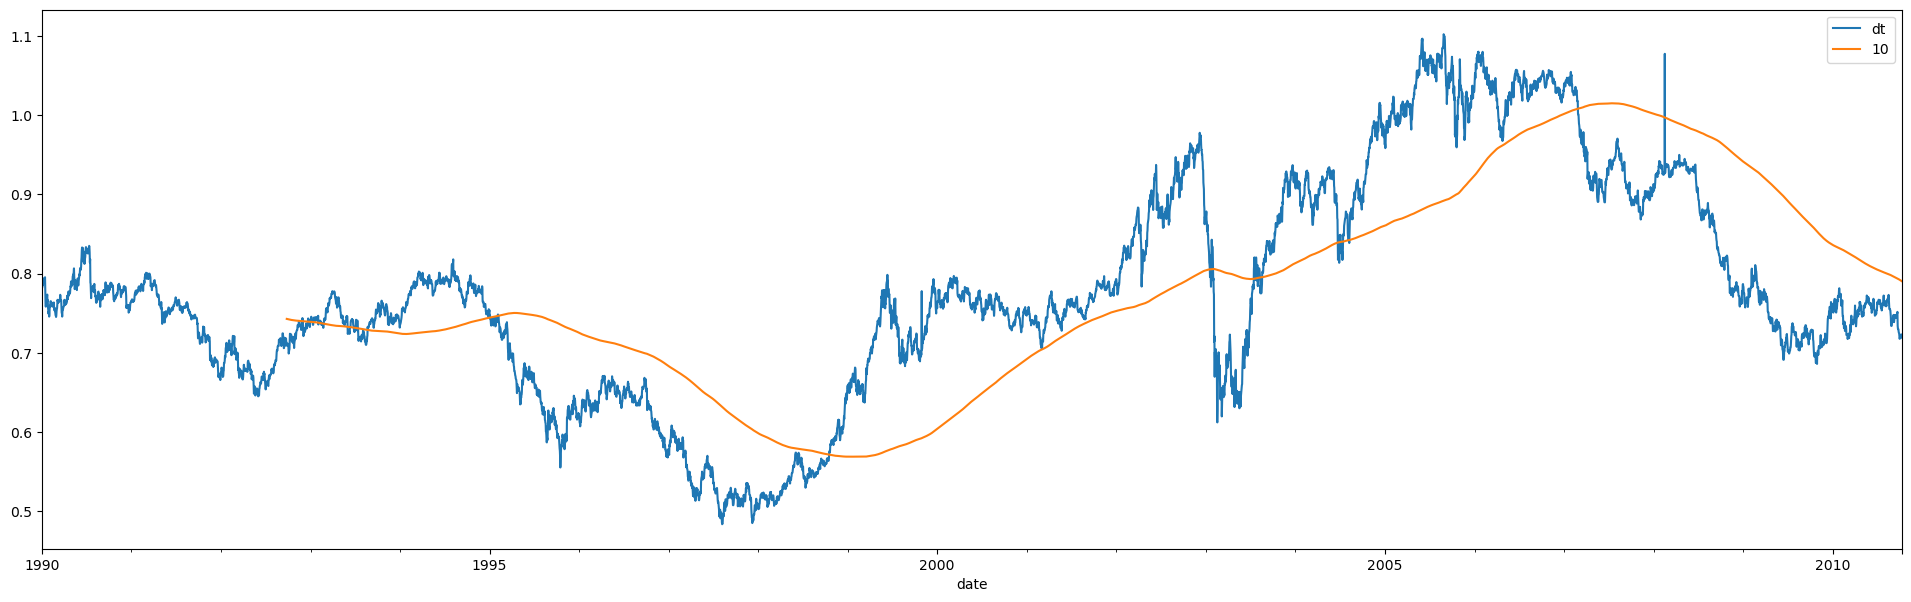

In [70]:
plt.figure(figsize=(24,7))
dt.Ex_rate.plot(label="dt")
pred = pd.DataFrame()
pred["Moving_Avg"] = dt["Ex_rate"].rolling(1000).mean()
pred["Moving_Avg"].plot(label=str(10))
plt.legend(loc='best')

In [71]:
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing #Holt's Winter model

In [72]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [73]:
hwe_model_mul_add = ExponentialSmoothing(train["Ex_rate"],seasonal="mul",trend="additive",seasonal_periods=12).fit() 
pred_hwe_mul_add = pd.DataFrame()
pred_hwe_mul_add["holt_winter_mul"] = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
MAPE(pred_hwe_mul_add["holt_winter_mul"] ,test.Ex_rate)

C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


5.911975115924828

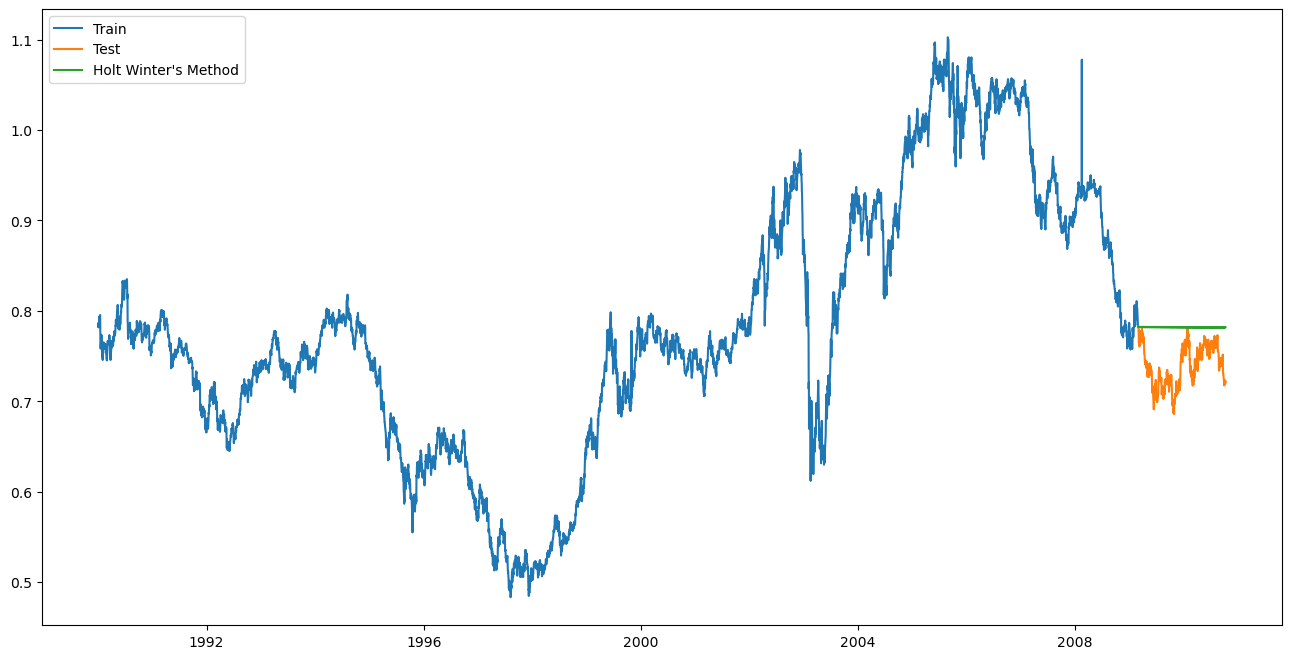

In [30]:
plt.figure(figsize=(16,8))
plt.plot(train["Ex_rate"], label='Train')
plt.plot(test["Ex_rate"], label='Test')
plt.plot(pred_hwe_mul_add["holt_winter_mul"], label="Holt Winter's Method")
plt.legend(loc='best')
plt.show()

In [74]:
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = [12, 24]

In [75]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from itertools import product
best_model = None
best_aic = float('inf')
best_params = None

for trend,seasonal,seasonal_period in product(trend_options,seasonal_options,seasonal_periods):
    try:
        if trend is None and seasonal is not None:
            continue
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period).fit()
        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            best_model = model
            best_params = (trend, seasonal, seasonal_period)
    except Exception as e:
        print(f"Combination (trend={trend}, seasonal={seasonal}, seasonal_period={seasonal_period}) failed: {e}")
        continue    

C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rajiv\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Best Model: Trend=None, Seasonal=None, Seasonal Periods=12
Best AIC: -71392.69441494028


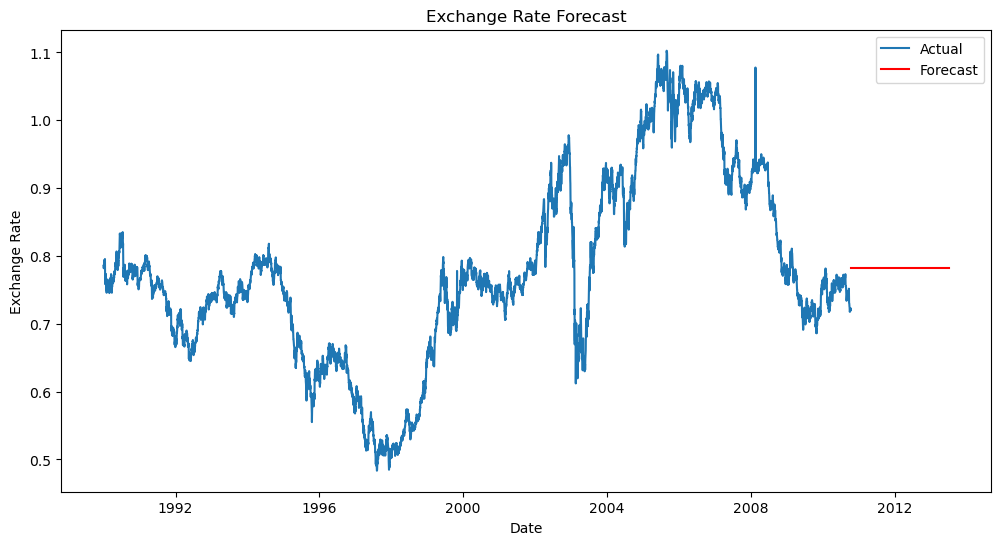

In [76]:
if best_model is not None:
    # Print the best model parameters
    print(f'Best Model: Trend={best_params[0]}, Seasonal={best_params[1]}, Seasonal Periods={best_params[2]}')
    print(f'Best AIC: {best_aic}')

    # Forecast the next 1000 days
    forecast_steps = 1000
    forecast_values = best_model.forecast(steps=forecast_steps)

    # Plot the actual values and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(dt.index, dt['Ex_rate'], label='Actual')
    plt.plot(pd.date_range(dt.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast_values, label='Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.title('Exchange Rate Forecast')
    plt.legend()
    plt.show()
else:
    print("No suitable model found.")

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Define functions to compute error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Extract actual values for comparison
actual_values = test

# Compute error metrics for ARIMA model
arima_forecast = forecast_values[:len(test)]

arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = mean_absolute_percentage_error(test, arima_forecast)

print(f"ARIMA Model - MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}")

# Assuming best_model is the Exponential Smoothing model fitted earlier
exp_smooth_forecast = best_model.forecast(steps=len(test))

exp_smooth_mae = mean_absolute_error(test, exp_smooth_forecast)
exp_smooth_rmse = np.sqrt(mean_squared_error(test, exp_smooth_forecast))
exp_smooth_mape = mean_absolute_percentage_error(actual_values, exp_smooth_forecast)

print(f"Exponential Smoothing Model - MAE: {exp_smooth_mae}, RMSE: {exp_smooth_rmse}, MAPE: {exp_smooth_mape}")

# Compare and conclude
if arima_mae < exp_smooth_mae and arima_rmse < exp_smooth_rmse and arima_mape < exp_smooth_mape:
    print("The ARIMA model yields better performance for forecasting exchange rates in this dataset.")
else:
    print("The Exponential Smoothing model yields better performance for forecasting exchange rates in this dataset.")


ARIMA Model - MAE: 0.04340543584783779, RMSE: 0.04889382119405761, MAPE: 2009-03-02 00:00:00   NaN
2009-03-03 00:00:00   NaN
2009-03-04 00:00:00   NaN
2009-03-05 00:00:00   NaN
2009-03-06 00:00:00   NaN
                       ..
2010-10-07 00:00:00   NaN
2010-10-08 00:00:00   NaN
2010-10-09 00:00:00   NaN
2010-10-10 00:00:00   NaN
Ex_rate               NaN
Length: 589, dtype: float64
Exponential Smoothing Model - MAE: 0.04340543584783779, RMSE: 0.04889382119405761, MAPE: 2009-03-02 00:00:00   NaN
2009-03-03 00:00:00   NaN
2009-03-04 00:00:00   NaN
2009-03-05 00:00:00   NaN
2009-03-06 00:00:00   NaN
                       ..
2010-10-07 00:00:00   NaN
2010-10-08 00:00:00   NaN
2010-10-09 00:00:00   NaN
2010-10-10 00:00:00   NaN
Ex_rate               NaN
Length: 589, dtype: float64
The Exponential Smoothing model yields better performance for forecasting exchange rates in this dataset.


C:\Users\rajiv\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\rajiv\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
